In [1]:
# data: Streaming_History_Audio_2023-2024_5
import json
import pandas as pd
from datetime import datetime

# Load JSON file
file_path = 'Streaming_History_Audio_2023-2024_5.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Convert timestamp (ts) to datetime and filter for 2024 tracks
df['ts'] = pd.to_datetime(df['ts'])
df = df[df['ts'].dt.year == 2024]

# Drop unnecessary columns for initial cleaning
columns_to_keep = [
    'ts', 'platform', 'ms_played', 'conn_country',
    'master_metadata_track_name', 'master_metadata_album_artist_name',
    'master_metadata_album_album_name', 'skipped', 'reason_start',
    'reason_end', 'shuffle', 'offline', 'incognito_mode'
]
df = df[columns_to_keep]

# Save the cleaned DataFrame for subsequent analyses
df.reset_index(drop=True, inplace=True)

# Display initial statistics
print("Dataframe Shape:", df.shape)
print("Columns Available:", df.columns)
print(df.head())


Dataframe Shape: (8703, 13)
Columns Available: Index(['ts', 'platform', 'ms_played', 'conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'skipped', 'reason_start',
       'reason_end', 'shuffle', 'offline', 'incognito_mode'],
      dtype='object')
                         ts platform  ms_played conn_country  \
0 2024-01-01 00:09:52+00:00      ios     531347           MX   
1 2024-01-01 00:10:20+00:00      ios      26020           MX   
2 2024-01-01 00:10:34+00:00      ios      11493           MX   
3 2024-01-01 00:10:48+00:00      ios       2345           MX   
4 2024-01-01 00:10:50+00:00      ios          0           MX   

  master_metadata_track_name master_metadata_album_artist_name  \
0       The Weight of Dreams                   Greta Van Fleet   
1                       Juno                            Choker   
2                 Heat Above                   Greta Van Fleet   
3       The Weight of 

In [5]:
# Top 20 Artists
top_artists = (
    df.groupby('master_metadata_album_artist_name')
    .agg(total_play_time=('ms_played', 'sum'), play_count=('master_metadata_album_artist_name', 'count'))
    .sort_values('total_play_time', ascending=False)
    .head(20)
)

# Top 20 Tracks with Artist Name
top_tracks = (
    df.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name'])
    .agg(
        total_play_time=('ms_played', 'sum'),
        play_count=('master_metadata_track_name', 'count')
    )
    .sort_values('total_play_time', ascending=False)
    .head(20)
)

# Top 20 Albums
top_albums = (
    df.groupby(['master_metadata_album_album_name', 'master_metadata_album_artist_name'])
    .agg(
        total_play_time=('ms_played', 'sum'),
        play_count=('master_metadata_album_album_name', 'count')
    )
    .sort_values('total_play_time', ascending=False)
    .head(20)
)

# Display Results
print("\n=== Top 20 Artists ===")
print(top_artists)

print("\n=== Top 20 Tracks ===")
print(top_tracks)

print("\n=== Top 20 Albums ===")
print(top_albums)



=== Top 20 Artists ===
                                   total_play_time  play_count
master_metadata_album_artist_name                             
Greta Van Fleet                           57320512         239
Michael Jackson                           40907963         224
Mustafa                                   36841459         225
Lucky Daye                                36769154         219
Billie Eilish                             33387685         185
Elmiene                                   31497249         178
Jorja Smith                               29825902         197
Cleo Sol                                  25730220         151
UMI                                       23788159         146
Orion Sun                                 22384980         178
Charli xcx                                21530479         207
Asha Imuno                                20339225         183
Angèle                                    19965776         109
Sampha                         

In [11]:
# Convert 'ts' to datetime if not already done
df['ts'] = pd.to_datetime(df['ts'])

# Calculate time differences in seconds between consecutive plays
df['time_diff'] = df['ts'].diff().dt.total_seconds()

# Identify streaks: Breaks of more than 5 minutes (300 seconds) end a streak
streaks = (df['time_diff'] > 300).cumsum()

# Aggregate streak information
longest_streak = (
    df.groupby(streaks)
    .agg(
        streak_duration=('ms_played', 'sum'),
        track_count=('master_metadata_track_name', 'count'),
        top_artists=(
            'master_metadata_album_artist_name',
            lambda x: x.mode().iloc[0] if not x.mode().empty else "No data"
        )
    )
    .sort_values('streak_duration', ascending=False)
    .head(3)
)

# Convert the streak duration from milliseconds to minutes
longest_streak['streak_duration'] = longest_streak['streak_duration'] / 1000 / 60  # Convert ms to minutes

print("\n=== Longest Listening Streak (in minutes) ===")
print(longest_streak[['streak_duration', 'top_artists']])  # Show streak duration in minutes and top artist



=== Longest Listening Streak (in minutes) ===
           streak_duration   top_artists
time_diff                               
190             208.243133  Lil Uzi Vert
417             137.000100      Cleo Sol
358             122.810433       Solange


In [13]:
# Count the number of skipped tracks
skipped_tracks = df[df['skipped'] == True]

# Calculate the skip rate
skipped_count = len(skipped_tracks)
non_skipped_count = len(df) - skipped_count

# Calculate the skip rate
skip_rate = skipped_count / len(df)

# Display results
print(f"Tracks Skipped: {skipped_count}")
print(f"Tracks Not Skipped: {non_skipped_count}")
print(f"Skip Rate: {skip_rate:.2f}")


Tracks Skipped: 3209
Tracks Not Skipped: 5494
Skip Rate: 0.37


In [14]:
# Count how many tracks were played offline
offline_tracks = df[df['offline'] == True]

# Calculate the offline listening rate
offline_count = len(offline_tracks)
offline_rate = offline_count / len(df)

# Display results
print(f"Offline Tracks Played: {offline_count}")
print(f"Total Tracks Played: {len(df)}")
print(f"Offline Listening Rate: {offline_rate:.2f}")


Offline Tracks Played: 3789
Total Tracks Played: 8703
Offline Listening Rate: 0.44


In [17]:
# Count how many tracks were played in incognito mode
incognito_tracks = df[df['incognito_mode'] == True]

# Calculate the incognito listening rate
incognito_count = len(incognito_tracks)
incognito_rate = incognito_count / len(df)

# Display results
print(f"Incognito Mode Tracks Played: {incognito_count}")
print(f"Total Tracks Played: {len(df)}")
print(f"Incognito Mode Listening Rate: {incognito_rate:.4f}")


Incognito Mode Tracks Played: 8
Total Tracks Played: 8703
Incognito Mode Listening Rate: 0.0009


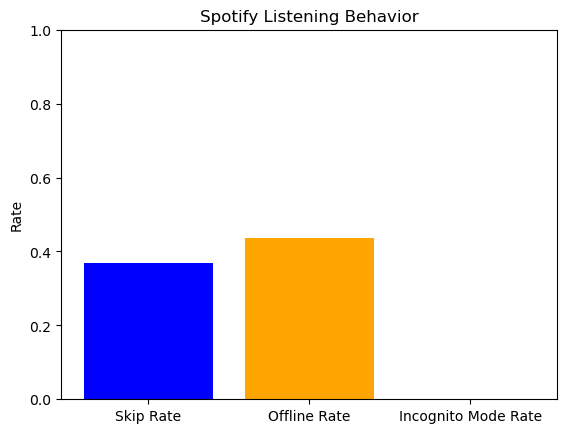

In [18]:
import matplotlib.pyplot as plt

# Data for plotting
labels = ["Skip Rate", "Offline Rate", "Incognito Mode Rate"]
values = [skip_rate, offline_rate, incognito_rate]

# Plot the bar chart
plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.ylabel('Rate')
plt.title('Spotify Listening Behavior')
plt.ylim(0, 1)
plt.show()


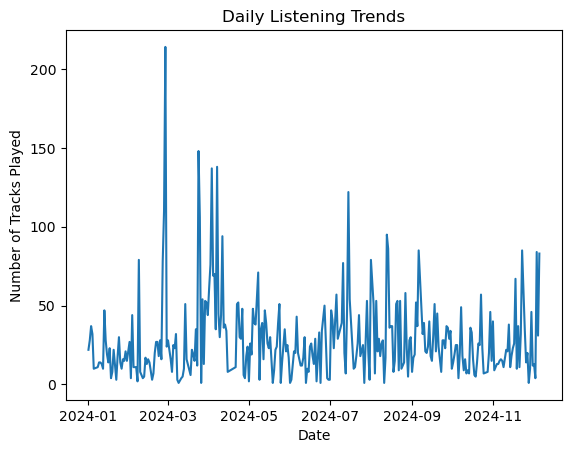

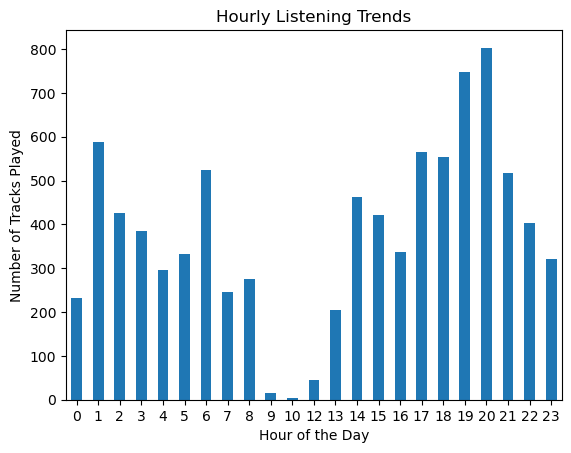

In [19]:
# Extract date and time components from timestamp for analysis
df['date'] = df['ts'].dt.date
df['hour'] = df['ts'].dt.hour

# Group by date to analyze daily listening patterns
daily_listening = df.groupby('date').size()

# Group by hour to analyze hourly listening patterns
hourly_listening = df.groupby('hour').size()

# Plot daily listening trends
daily_listening.plot(kind='line', title="Daily Listening Trends")
plt.ylabel("Number of Tracks Played")
plt.xlabel("Date")
plt.show()

# Plot hourly listening trends
hourly_listening.plot(kind='bar', title="Hourly Listening Trends")
plt.ylabel("Number of Tracks Played")
plt.xlabel("Hour of the Day")
plt.xticks(rotation=0)
plt.show()


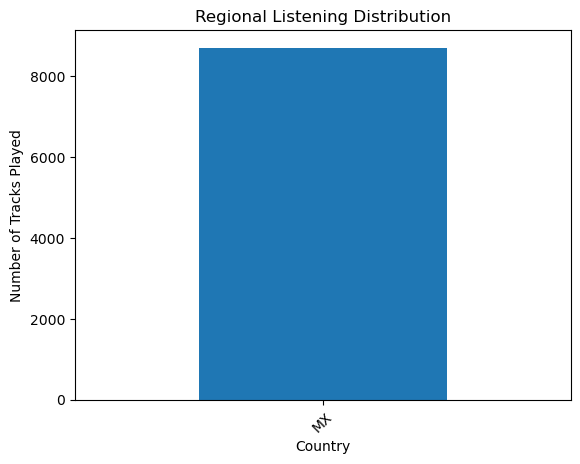

In [20]:
# Count the number of tracks played by country
country_listening = df['conn_country'].value_counts()

# Plot the regional listening distribution
country_listening.plot(kind='bar', title="Regional Listening Distribution")
plt.ylabel("Number of Tracks Played")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()


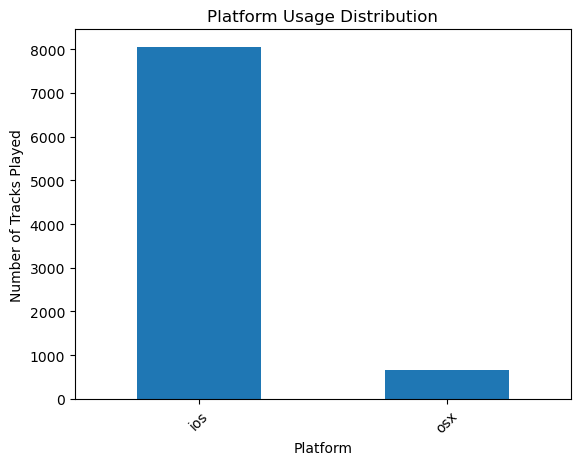

In [21]:
# Count the number of tracks played by platform
platform_listening = df['platform'].value_counts()

# Plot the platform distribution
platform_listening.plot(kind='bar', title="Platform Usage Distribution")
plt.ylabel("Number of Tracks Played")
plt.xlabel("Platform")
plt.xticks(rotation=45)
plt.show()


In [25]:
# Create a summary dictionary
summary = {
    "Total Tracks Played": len(df),
    "Total Countries Listened From": len(country_listening),
    "Total Platforms Used": len(platform_listening),
    "Peak Hour of Listening": hourly_listening.idxmax(),
    "Peak Day of Listening": daily_listening.idxmax()
}

# Display summary
for metric, value in summary.items():
    print(f"{metric}: {value}")


Total Tracks Played: 8703
Total Countries Listened From: 1
Total Platforms Used: 2
Peak Hour of Listening: 20
Peak Day of Listening: 2024-02-28


In [27]:
# Filtramos las canciones que no fueron saltadas
no_skipped_tracks = df[df['skipped'] == False]

# Contamos cuántas veces se ha reproducido cada track sin ser saltado
track_play_count = no_skipped_tracks.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name']).size()

# Mostramos las 20 canciones más reproducidas sin ser saltadas
print("Top 20 Tracks No Saltados:")
for track, count in track_play_count.sort_values(ascending=False).head(20).items():
    track_name, artist_name = track
    print(f"Track: {track_name}, Artist: {artist_name}, Reproducciones: {count}")


Top 20 Tracks No Saltados:
Track: L’AMOUR DE MA VIE, Artist: Billie Eilish, Reproducciones: 25
Track: CHIHIRO, Artist: Billie Eilish, Reproducciones: 20
Track: Nothing on Me, Artist: Cleo Sol, Reproducciones: 18
Track: LUNCH, Artist: Billie Eilish, Reproducciones: 18
Track: Love Will Lead You There, Artist: Cleo Sol, Reproducciones: 16
Track: What Happened, Mohamed?, Artist: Mustafa, Reproducciones: 16
Track: can friends kiss?, Artist: Camila Cabello, Reproducciones: 15
Track: Orion, Artist: Orion Sun, Reproducciones: 15
Track: Birds Gave Up, Artist: Orion Sun, Reproducciones: 15
Track: Old Friends, Artist: Cleo Sol, Reproducciones: 15
Track: Name of God, Artist: Mustafa, Reproducciones: 15
Track: Imaan, Artist: Mustafa, Reproducciones: 15
Track: BIRDS OF A FEATHER, Artist: Billie Eilish, Reproducciones: 14
Track: Golden Child (Jealous), Artist: Cleo Sol, Reproducciones: 14
Track: Betterrr (Live), Artist: Orion Sun, Reproducciones: 14
Track: Démons, Artist: Angèle, Reproducciones: 14
T

In [28]:
shuffle_usage = df['shuffle'].value_counts()
print("Shuffle Mode Usage:")
print(shuffle_usage)


Shuffle Mode Usage:
shuffle
False    5075
True     3628
Name: count, dtype: int64


In [29]:
complete_vs_skipped = df['skipped'].value_counts(normalize=True)
print("Complete vs Skipped Listening:")
print(complete_vs_skipped)


Complete vs Skipped Listening:
skipped
False    0.631277
True     0.368723
Name: proportion, dtype: float64


In [52]:
# Convert the 'ts' field to datetime format
df['ts'] = pd.to_datetime(df['ts'], format='%Y-%m-%d %H:%M:%S')

# Add a 'month' column to the DataFrame to extract the month of each entry
df['month'] = df['ts'].dt.month

def get_top_5_per_month(df, group_by_col, title):
    # Grouping by month and the selected column, then summing the total 'ms_played' for each group
    top_per_month = df.groupby(['month', group_by_col])['ms_played'].sum().reset_index()

    # Sorting by month and getting the top 5 for each month
    top_per_month = top_per_month.groupby('month').apply(lambda x: x.nlargest(5, 'ms_played')).reset_index(drop=True)

    print(f"------------------------------------")
    print(f"------------------------------------")
    print(f"\nTop 5 {title} per Month:")
    for month in range(1, 13):
        print(f"\nMonth: {month}")
        month_data = top_per_month[top_per_month['month'] == month]
        month_data.loc[:, 'rank'] = month_data['ms_played'].rank(method='first', ascending=False).astype(int)

        # Use .loc to modify the DataFrame safely
        for idx, row in month_data.iterrows():
            if row['rank'] <= 5:  # Display only the top 5 per month
                print(f"Rank {row['rank']}: {row[group_by_col]} - Total Play Time (ms): {row['ms_played']}")


# Get Top 5 artists per month
get_top_5_per_month(df, 'master_metadata_album_artist_name', 'Artists')

# Get Top 5 songs (with artists) per month
df['song_with_artist'] = df['master_metadata_track_name'] + ' - ' + df['master_metadata_album_artist_name']
get_top_5_per_month(df, 'song_with_artist', 'Songs (with Artists)')

# Get Top 5 albums (with artists) per month
df['album_with_artist'] = df['master_metadata_album_album_name'] + ' - ' + df['master_metadata_album_artist_name']
get_top_5_per_month(df, 'album_with_artist', 'Albums (with Artists)')


------------------------------------
------------------------------------

Top 5 Artists per Month:

Month: 1
Rank 1: Greta Van Fleet - Total Play Time (ms): 53129743
Rank 2: Michael Jackson - Total Play Time (ms): 5829624
Rank 3: Frank Ocean - Total Play Time (ms): 2024719
Rank 4: UMI - Total Play Time (ms): 1883635
Rank 5: Katelyn Tarver - Total Play Time (ms): 1649561

Month: 2
Rank 1: Michael Jackson - Total Play Time (ms): 33313376
Rank 2: Greta Van Fleet - Total Play Time (ms): 3431445
Rank 3: Kevin Abstract - Total Play Time (ms): 3004133
Rank 4: Blood Orange - Total Play Time (ms): 2546273
Rank 5: Lil Uzi Vert - Total Play Time (ms): 1873897

Month: 3
Rank 1: UMI - Total Play Time (ms): 10002600
Rank 2: Orion Sun - Total Play Time (ms): 7919861
Rank 3: Cleo Sol - Total Play Time (ms): 7631895
Rank 4: Jorja Smith - Total Play Time (ms): 7417396
Rank 5: Sampha - Total Play Time (ms): 7038311

Month: 4
Rank 1: Cleo Sol - Total Play Time (ms): 16168482
Rank 2: Jorja Smith - Total P

/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipykernel_2119/3772204025.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_data.loc[:, 'rank'] = month_data['ms_played'].rank(method='first', ascending=False).astype(int)
/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipykernel_2119/3772204025.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_data.loc[:, 'rank'] = month_data['ms_played'].rank(method='first', ascending=False).astype(int)
/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipy